#LightGBM（アーリーストッピング）の学習→予測→評価

In [ ]:
# # Colabでバージョンを変更するとき、コメントアウトして実行してください
# !pip install pandas==1.5.3
# !pip install numpy==1.22.4
# !pip install matplotlib==3.7.1
# !pip install seaborn==0.12.2
# !pip install scikit-learn==1.2.2
# !pip install lightgbm==3.3.5

In [ ]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
# バージョンの確認
import matplotlib
import sklearn
import lightgbm as lgb
print(pd.__version__) 
print(np.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(sklearn.__version__) 
print(lgb.__version__)

1.5.3
1.22.4
3.7.1
0.12.2
1.2.2
3.3.5


In [ ]:
# データセットの読み込み
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
df.columns =['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
#df.head()

In [ ]:
# 前処理

# 文字列の半角スペース削除
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']
for s in cat_cols:
  df[s] =df[s].str.replace(' ', '')

# United-Statesのレコードに絞り特徴量native-countryを削除
df = df[df['native-country'].isin(['United-States'])]
df = df.drop(['native-country'], axis=1)
df.reset_index(inplace=True, drop=True)

# 正解ラベルの数値への置換
df['income'] = df['income'].replace('<=50K', 0)
df['income'] = df['income'].replace('>50K', 1)

#print(df.shape)
#df.head()

In [ ]:
# 特徴量と目的変数の設定
X = df.drop(['income'], axis=1)
y = df['income']

In [ ]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (23336, 13)  y_trainの形状： (23336,)  X_testの形状： (5834, 13)  y_testの形状： (5834,)


In [ ]:
# カテゴリ変数の前処理

# カテゴリ変数のlabel encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

    # データ型をcategory型に変換
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

#X_train.info()

In [ ]:
# 学習データの20%を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (18668, 13)  y_trの形状： (18668,)  X_vaの形状： (4668, 13)  y_vaの形状： (4668,)


In [ ]:
# ハイパーパラメータの設定
import lightgbm as lgb

lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

params = {
    'objective': 'binary',
    'num_leaves': 5,
    'seed': 0,
    'verbose': -1,
}

# 誤差プロットの格納用データ
evals_result = {} 

In [ ]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=500,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(10),
                             lgb.log_evaluation(100),
                             lgb.record_evaluation(evals_result)])

Training until validation scores don't improve for 10 rounds
[100]	train's binary_logloss: 0.285093	valid's binary_logloss: 0.297689
[200]	train's binary_logloss: 0.271357	valid's binary_logloss: 0.291118
Early stopping, best iteration is:
[200]	train's binary_logloss: 0.271357	valid's binary_logloss: 0.291118


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

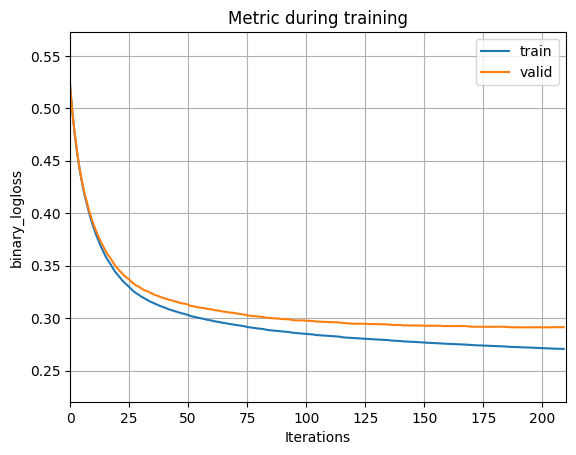

In [ ]:
# 学習データと検証データの誤差プロット
lgb.plot_metric(evals_result)

In [ ]:
# 学習が停止したブースティング回数
model.best_iteration

200

In [ ]:
# 検証データの予測と評価
y_va_pred_proba = model.predict(X_va, num_iteration=model.best_iteration) # ラベル1の確率
print('ラベル1の確率：', y_va_pred_proba)
y_va_pred = np.round(y_va_pred_proba) # 確率をラベル0 or 1に変換
print('予測ラベル値：', y_va_pred)

ac_score = accuracy_score(y_va, y_va_pred)
print('accuracy = %.2f' % (ac_score))

f1 = f1_score(y_va, y_va_pred)
print('F1-score = %.2f' % (f1))

ラベル1の確率： [0.03758662 0.00051379 0.16303104 ... 0.00878358 0.07152312 0.41445192]
予測ラベル値： [0. 0. 0. ... 0. 0. 0.]
accuracy = 0.87
F1-score = 0.70


In [ ]:
# テストデータの予測と評価
y_test_pred_proba = model.predict(X_test, num_iteration=model.best_iteration) # ラベル1の確率
print('ラベル1の確率：', y_test_pred_proba)
y_test_pred = np.round(y_test_pred_proba) # 確率をラベル0 or 1に変換
print('予測ラベル値：', y_test_pred)

ac_score = accuracy_score(y_test, y_test_pred)
print('accuracy = %.2f' % (ac_score))

f1 = f1_score(y_test, y_test_pred)
print('F1-score = %.2f' % (f1))

ラベル1の確率： [0.02738649 0.1740557  0.19527131 ... 0.99293736 0.04875194 0.04739031]
予測ラベル値： [0. 0. 0. ... 1. 0. 0.]
accuracy = 0.86
F1-score = 0.68


Text(45.722222222222214, 0.5, 'label')

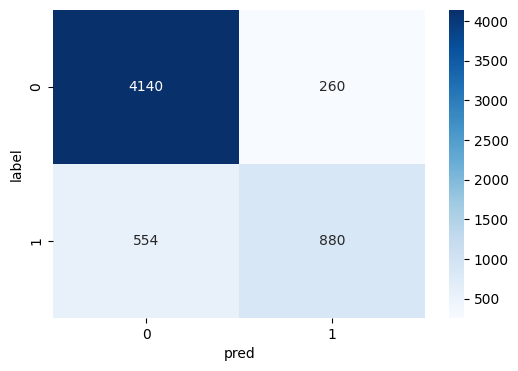

In [ ]:
# 混同行列
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('pred')
plt.ylabel('label')

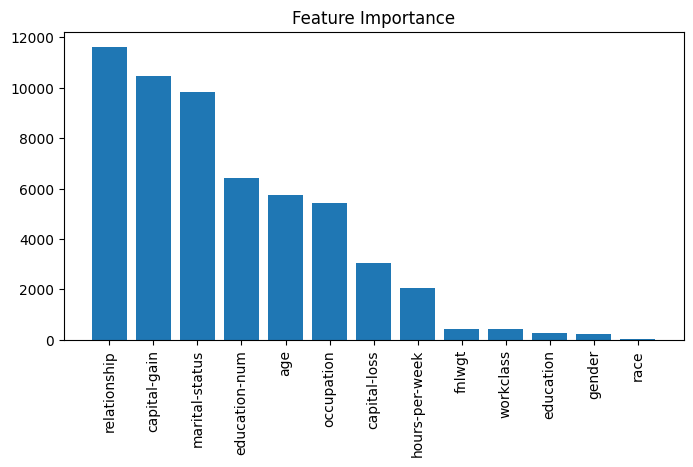

In [ ]:
# 特徴量重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量重要度
indices = np.argsort(importances)[::-1] # 特徴量重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title("Feature Importance") # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示

#クロスバリデーション

In [ ]:
# 層化分割のクロスバリデーション
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

params = {
    'objective': 'binary',
    'num_leaves': 5,
    'seed': 0,
    'verbose': -1,
}

# 格納用データの作成
accuracy_scores = []
logloss_scores = []
models = []
oof = np.zeros(len(X_train))

# KFoldを用いて学習データを5分割してモデルを作成
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train, y_train)):
    X_tr = X_train.iloc[tr_idx]
    X_va = X_train.iloc[va_idx]    
    y_tr = y_train.iloc[tr_idx]
    y_va = y_train.iloc[va_idx]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=500,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(10),
                      lgb.log_evaluation(100)])

    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration) 
    accuracy = accuracy_score(y_va, np.round(y_va_pred))
    logloss = log_loss(y_va, y_va_pred)
    print(f'fold {fold+1} accuracy_score: {accuracy:4f}   logloss: {logloss:4f}')
    print('')
    
    # スコア、モデル、予測値の格納
    accuracy_scores.append(accuracy)
    logloss_scores.append(logloss)
    models.append(model)
    oof[va_idx] = y_va_pred

# クロスバリデーションの平均スコア
cv_accuracy_score = np.mean(accuracy_scores)
cv_logloss_score = np.mean(logloss_scores)

print(f'CV accuracy score: {cv_accuracy_score:4f}    CV logloss score: {cv_logloss_score:4f} ')

Training until validation scores don't improve for 10 rounds
[100]	train's binary_logloss: 0.288706	valid's binary_logloss: 0.287306
[200]	train's binary_logloss: 0.275793	valid's binary_logloss: 0.278749
Early stopping, best iteration is:
[278]	train's binary_logloss: 0.268845	valid's binary_logloss: 0.275477
fold 1 accuracy_score: 0.873179   logloss: 0.275477

Training until validation scores don't improve for 10 rounds
[100]	train's binary_logloss: 0.287829	valid's binary_logloss: 0.29263
[200]	train's binary_logloss: 0.274043	valid's binary_logloss: 0.284794
Early stopping, best iteration is:
[212]	train's binary_logloss: 0.272111	valid's binary_logloss: 0.283514
fold 2 accuracy_score: 0.875509   logloss: 0.283514

Training until validation scores don't improve for 10 rounds
[100]	train's binary_logloss: 0.286818	valid's binary_logloss: 0.29414
[200]	train's binary_logloss: 0.27296	valid's binary_logloss: 0.286963
Early stopping, best iteration is:
[243]	train's binary_logloss: 0.2

In [ ]:
# foldごとの検証データの正解率
accuracy_scores

[0.8731790916880892,
 0.8755088922219841,
 0.8688665095350332,
 0.8744375401757017,
 0.8643668309406471]